In [2]:
import numpy as np
from numpy.random import RandomState, SeedSequence, MT19937
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
def make_gamma_spike_train(k, rate, tend=None, Nev=None, refractory_period=0, random_state=None):
    from scipy.stats import gamma
    if Nev is None and tend is not None:
        Nev = int(np.ceil(tend * rate))
    ISIs = []
    while len(ISIs) < Nev:
        ISI = gamma.rvs(k, loc=0, scale=1 / (k * rate), size=1, random_state=random_state)
        if ISI > refractory_period:
            ISIs.append(ISI)
    spks = np.cumsum(ISIs)
    if tend is not None:
        spks = spks[spks < tend]
    return spks


make_poisson_spike_train = lambda rate, tend=None, Nev=None, refractory_period=0, random_state=None: \
    make_gamma_spike_train(1, rate, tend, Nev, refractory_period, random_state)

#440154
#414487
#2a788e
#22a884
#7ad151
#fde725


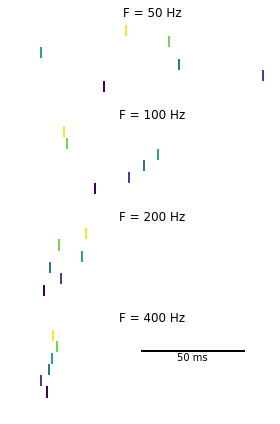

In [33]:
seed = 50
rs = RandomState(MT19937(SeedSequence(seed)))
n_spikes = 6
cmap = plt.get_cmap('viridis', n_spikes)
rates = (50,100,200,400)
fig,ax = plt.subplots(4, 1, figsize=(4,len(rates)*1.5), sharex=True)
for i,rate in enumerate(rates):
    spks = make_poisson_spike_train(rate, Nev=n_spikes, random_state=rs)
    idx = np.random.permutation(n_spikes)
    for j,spk in enumerate(spks):
        ax[i].plot(spk + np.zeros(2), [idx[j],idx[j]+0.8], color=cmap(idx[j]), lw=2)
    ax[i].set_title(f'F = {rate} Hz')
    ax[i].axis('off')
x = np.array([50e-3, 100e-3])
y = len(rates) + np.zeros(2)
ax[-1].plot(x, y, 'k', lw=2)
ax[-1].text(x.sum() / 2, y[0] - 0.1, f'{np.diff(x)[0]*1e3:.0f} ms', horizontalalignment='center', verticalalignment='top')
fig.tight_layout()
fig.savefig('poisson.pdf')
for i in range(n_spikes):
    col = cmap(i)
    print(matplotlib.colors.rgb2hex(col))

In [4]:
dt = 1         # [ms]
tstop = 1e3    # [ms]
seed = 100
rs = RandomState(MT19937(SeedSequence(seed)))
t = np.arange(0, tstop, dt)
n_samples = t.size
OU = np.zeros(n_samples)
rnd = rs.normal(size=n_samples)
mean = 0
stddev = 1
tau = 50
const = 2 * stddev**2 / tau
mu = np.exp(-dt / tau)
coeff = np.sqrt(const * tau / 2 * (1 - mu ** 2))
OU[0] = mean
for i in range(1,n_samples):
    OU[i] = mean + mu * (OU[i-1] - mean) + coeff * rnd[i]

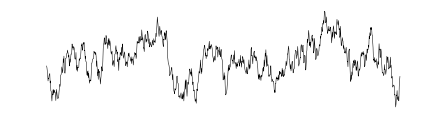

In [5]:
fig,ax = plt.subplots(1, 1, figsize=(6,2))
ax.plot(t, OU, 'k', lw=0.5)
ax.axis('off')
fig.tight_layout()
fig.savefig('ou.pdf')

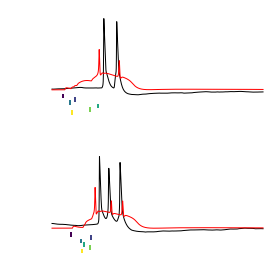

In [84]:
folder = '/Users/daniele/Postdoc/Research/CA3/OPTIMIZATIONS/A-thorny/DH070213C3/20191206232623_DH070213C3_/'
data_files = {100: folder + 'synaptic_activation_20210702-104747.npz',
              200: folder + 'synaptic_activation_20210702-105703.npz'}
burst_idx = {100: 1, 200: 4}
fig,ax = plt.subplots(2, 1, figsize=(4,4))
cmap = plt.get_cmap('viridis', 6)
for i,F in enumerate((100, 200)):
    data = np.load(data_files[F], allow_pickle=True)
    time = data['time']
    Vsoma = data['Vsoma']
    Vdend = data['Vdend']
    spike_times = data['spike_times']
    presyn_spike_times = [spike_times[burst_idx[F]] for spike_times in data['presyn_spike_times']]
    presyn_burst_times = data['presyn_burst_times']
    burst_time = presyn_burst_times[burst_idx[F]]
    idx, = np.where((time > burst_time - 5) & (time < burst_time + 150))
    ax[i].plot(time[idx] - burst_time, Vsoma[idx], 'k', lw=1, label='Soma')
    ax[i].plot(time[idx] - burst_time, Vdend[idx], 'r', lw=1, label='Dendrite')
    for j,presyn_spike_time in enumerate(presyn_spike_times - burst_time):
        ax[i].plot(presyn_spike_time + np.zeros(2), [-80 - j * 5, -80 - j * 5  + 4], color=cmap(j), lw=2)
    ax[i].set_ylim([-110,50])
    ax[i].axis('off')
fig.tight_layout()
fig.savefig('traces.pdf')